In [144]:
import pandas as pd
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#для анализа на sklearn (в самом конце)
from sklearn.linear_model import SGDClassifier

#для датасета
import random
from torch.utils.data.sampler import SubsetRandomSampler

#для нейросети
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
import torch.nn as nn
import torch

#для графика loss
import matplotlib.pyplot as plt

In [2]:
#класс для перевода text2vec пир помощи rubert

class BertClass (object):
    def __init__  (self):
        self.tokenizer = BertTokenizer.from_pretrained('./rubert')
        self.model = BertModel.from_pretrained('./rubert')
        self.model.eval()

    def text2vec (self, text):
        marked_text = "[CLS] " + text + " [SEP]"

        tokenized_text = self.tokenizer.tokenize(marked_text)[:500]
        indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)
        segments_ids = [1] * len(tokenized_text)

        tokens_tensor = torch.tensor([indexed_tokens])
        segments_tensors = torch.tensor([segments_ids])

        with torch.no_grad():
            encoded_layers, _ = self.model(tokens_tensor, segments_tensors)
        sentence_embedding = torch.mean(encoded_layers[len(encoded_layers) - 1], 1)[0]
        return sentence_embedding

bert = BertClass()

In [3]:
#берем таблицы
positive_dialogs_df = pd.read_excel(r'sentiment_train.xlsx', sheet_name='Positive', header=None, names=['dialog'])
negative_dialogs_df = pd.read_excel(r'sentiment_train.xlsx', sheet_name='Negative', header=None, names=['dialog'])

<h4>Анализируем по отдельности все сообщения (без привязки к чату)</h4>

<a>Здесь и далее label =  0 - негативный текст, 1 - позитивный</a>

In [54]:
#создаем сырой датасет

#получаем массивы текстов из чатов
positiveTextes = []
negativeTextes = []
for chat in negative_dialogs_df.dialog.tolist():
    for message in chat.split('\n'):
        if 'visitor' in message:
            message = message.replace('visitor:', '')
            if len(message.strip()) != 0:
                negativeTextes.append(message)
        if 'agent' in message:
            message = message.replace('agent:', '')
            if len(message.strip()) != 0:
                positiveTextes.append(message)

for chat in positive_dialogs_df.dialog.tolist():
    for message in chat.split('\n'):
        if 'visitor' in message:
            message = message.replace('visitor:', '')
        if 'agent' in message:
            message = message.replace('agent:', '')
        if len(message.strip()) != 0:
            positiveTextes.append(message)
            
textes = negativeTextes + positiveTextes

#преобразуем массивы текстов в массивы имбеддингов (сырой датасет)
rawData = torch.zeros(len(textes), 768)
rawLabels = torch.tensor([0.0] * len(negativeTextes) + [1.0] * len(positiveTextes))
for i in range(len(textes)):
    rawData[i] = bert.text2vec(textes[i])

In [55]:
#создаем конечный датасет

class MyDataset():
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

    def __len__(self):
        return len(self.labels)
    
dataset = MyDataset(rawData, rawLabels)

In [78]:
#разделяем датасет на train и val

test_split = 0.3

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(test_split * dataset_size)

random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=len(train_sampler), 
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=25,
                                          sampler=test_sampler)

print('длинна тренировочных данных: {}'.format(len(train_sampler)))
print('длинна тестовых данных: {}'.format(len(test_indices)))

длинна тренировочных данных: 101
длинна тестовых данных: 43


наименьший lossTest = 0.08960254490375519 на эпохе: 23


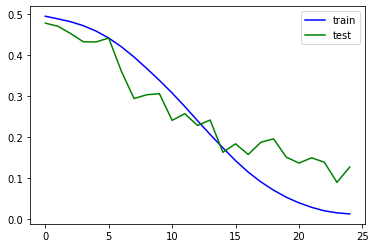

In [79]:
#создаем нейросеть и обучаем

%matplotlib inline

class TextClassifier(nn.Module):
    def __init__(self):
        super(TextClassifier, self).__init__()                    
        self.fc1 = nn.Linear(768, 256)  
        self.relu = nn.ReLU()                          
        self.fc2 = nn.Linear(256, 128)
        self.relu1 = nn.ReLU6()               
        self.fc3 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU6()  
        self.fc4 = nn.Linear(64, 1)
        self.sigm = nn.Sigmoid()
        
    def forward(self, x):                              
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu1(out)
        out = self.fc3(out)
        out = self.relu2(out)
        out = self.fc4(out)
        out = self.sigm(out)
        return out

textClassifier = TextClassifier()

learning_rate = 0.001
num_epochs = 25
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(textClassifier.parameters(), lr=learning_rate)

lossTrain = []
lossTest = []

autoStop = False #False True #автоматически остановить обучение при достижении минимальной ошибки
prevLoss = 1
for epoch in range(int(num_epochs)):
    trainData, trainLabels = next(iter(train_loader))
    optimizer.zero_grad()
    outputs = textClassifier(trainData)
    loss = criterion(outputs, trainLabels.view(-1, 1))
    loss.backward()
    optimizer.step() 
    lossTrain.append(float(loss))
        
    testData, valLabels = next(iter(test_loader))
    outputs = textClassifier(testData)
    loss = criterion(outputs, valLabels.view(-1, 1))
    lossTest.append(float(loss))
    
    if (prevLoss < loss) and (autoStop):
        break
    else:
        prevLoss = loss

plt.plot(lossTrain, '-b', label='train')
plt.plot(lossTest, '-g', label='test')
plt.legend()
plt.draw()
print('наименьший lossTest = {} на эпохе: {}'.format(min(lossTest), lossTest.index(min(lossTest))))

In [91]:
#визуализируем FN и FP
for i in range(len(textes)):
    pred = float(textClassifier(rawData[i]))
    if float(rawLabels[i]) != round(pred):
        print('label = {0} pred = {1:.3f} text = {2}'.format(int(rawLabels[i]), pred, textes[i]))

label = 0 pred = 0.886 text =  Кирилл, что-то удалось узнать?
label = 0 pred = 0.995 text =  По проводу. через роутер. Не тяните время, настраивайте скорость. 
label = 1 pred = 0.276 text =  Куку- это ваш вопрос?
label = 1 pred = 0.007 text =  Не помню
label = 1 pred = 0.164 text =  в чат?
label = 1 pred = 0.061 text =  Корпус 15


In [100]:
torch.save(textClassifier.state_dict(), 'model.pkl')

<h4>Анализируем чаты целиком</h4>

In [120]:
#создаем класс для классификации чатов 

class ChatClassifier(object):
    def __init__(self, bertModel, classifyModel):
        self.bertModel = bertModel
        self.classifyModel = classifyModel
    
    def chatParsing (self, rawChat):
        clearChat = {'visitor':[], 'agent':[]}
        
        for message in rawChat.split('\n'):
            if 'visitor' in message:
                message = message.replace('visitor:', '').replace('agent:', '')
                if len(message.strip()) != 0:
                    clearChat['visitor'].append(message)
            if 'agent' in message:
                message = message.replace('agent:', '')
                if len(message.strip()) != 0:
                    clearChat['agent'].append(message)
        return clearChat
    
    def classifyChat(self, rawChat, needToReadAgent=False):
        chat = self.chatParsing(rawChat)
        roles = ['visitor']
        if needToReadAgent:
            roles.append('agent')
        positiveLevel = 0
        numberOfMessage = 0
        
        for role in roles:
            for message in chat[role]:
                textEmbedding = self.bertModel.text2vec(message)
                positiveLevel += float(self.classifyModel(textEmbedding))
                numberOfMessage += 1
        positiveLevel = positiveLevel / numberOfMessage 
        
        return positiveLevel
        
chatClassifier = ChatClassifier(bertModel=bert, classifyModel=textClassifier)

In [143]:
#берем таблицы
positive_dialogs_df = pd.read_excel(r'sentiment_train.xlsx', sheet_name='Positive', header=None, names=['dialog'])
negative_dialogs_df = pd.read_excel(r'sentiment_train.xlsx', sheet_name='Negative', header=None, names=['dialog'])

In [142]:
#результат для чатов, учитываются все сообщения (и агента и гостя)
positiveLevels = []
chatLoss = 0
numberOfChats = 0
positiveOrNegative = []

for chat in negative_dialogs_df.dialog.tolist():
    positiveLevel = chatClassifier.classifyChat(chat)
    positiveLevels.append(positiveLevel)
    chatLoss += positiveLevel
    numberOfChats += 1
    positiveOrNegative.append('negative')

for chat in positive_dialogs_df.dialog.tolist():
    positiveLevel = chatClassifier.classifyChat(chat)
    positiveLevels.append(positiveLevel)
    chatLoss += 1 - positiveLevel
    numberOfChats += 1
    positiveOrNegative.append('positive')
    
print('итоговая ошибка по чатам = {}'. format(chatLoss / numberOfChats))

finalTable = pd.concat([negative_dialogs_df, positive_dialogs_df], ignore_index=True)
finalTable['positiveLevel'] = positiveLevels
finalTable['positiveOrNegative'] = positiveOrNegative
finalTable

итоговая ошибка по чатам = 0.07829038082922732


,dialog,positiveLevel,positiveOrNegative
0,visitor: низкая скорость интернет\nagent: Уточ...,0.000859,negative
1,"visitor: Кирилл, не увидел ответ, удалось утрч...",0.297737,negative
2,visitor: Вы что творите?! При подключении скор...,0.349253,negative
3,visitor: Здравствуйте.\nvisitor: Мне до сих по...,0.039457,negative
4,"visitor: д. Софрино, Кировоградское шоссе 3.КО...",0.001190,negative
5,"visitor: Нет интернета, нет связи с тех поддер...",0.006186,negative
6,visitor: Куку\nagent: Уточните ваш вопрос?\nvi...,0.002774,negative
7,visitor: Сегодня снова не работает интернет!!!...,0.000607,negative
8,visitor: Добрый день! Не работает интернет..\n...,0.003124,negative
9,visitor: Когда у меня нормально будет работать...,0.002331,negative


In [141]:
#результат для чатов, учитываются все сообщения (и агента и гостя)
positiveLevels = []
chatLoss = 0
numberOfChats = 0
positiveOrNegative = []

for chat in negative_dialogs_df.dialog.tolist():
    positiveLevel = chatClassifier.classifyChat(chat, needToReadAgent=True)
    positiveLevels.append(positiveLevel)
    chatLoss += positiveLevel
    numberOfChats += 1
    positiveOrNegative.append('negative')

for chat in positive_dialogs_df.dialog.tolist():
    positiveLevel = chatClassifier.classifyChat(chat, needToReadAgent=True)
    positiveLevels.append(positiveLevel)
    chatLoss += 1 - positiveLevel
    numberOfChats += 1
    positiveOrNegative.append('positive')
    
print('итоговая ошибка по чатам = {}'. format(chatLoss / numberOfChats))

finalTable = pd.concat([negative_dialogs_df, positive_dialogs_df], ignore_index=True)
finalTable['positiveLevel'] = positiveLevels
finalTable['positiveOrNegative'] = positiveOrNegative
finalTable

итоговая ошибка по чатам = 0.2013883033989962


,dialog,positiveLevel,positiveOrNegative
0,visitor: низкая скорость интернет\nagent: Уточ...,0.333903,negative
1,"visitor: Кирилл, не увидел ответ, удалось утрч...",0.578525,negative
2,visitor: Вы что творите?! При подключении скор...,0.609404,negative
3,visitor: Здравствуйте.\nvisitor: Мне до сих по...,0.199024,negative
4,"visitor: д. Софрино, Кировоградское шоссе 3.КО...",0.498659,negative
5,"visitor: Нет интернета, нет связи с тех поддер...",0.254637,negative
6,visitor: Куку\nagent: Уточните ваш вопрос?\nvi...,0.184195,negative
7,visitor: Сегодня снова не работает интернет!!!...,0.500279,negative
8,visitor: Добрый день! Не работает интернет..\n...,0.287674,negative
9,visitor: Когда у меня нормально будет работать...,0.144816,negative


<h4>Вариант на чистом sklearn</h4>

In [104]:
#создаем датасет

positiveTextes = []
negativeTextes = []
for chat in negative_dialogs_df.dialog.tolist():
    for message in chat.split('\n'):
        if 'visitor' in message:
            message = message.replace('visitor:', '')
            if len(message.strip()) != 0:
                negativeTextes.append(message)
        if 'agent' in message:
            message = message.replace('agent:', '')
            if len(message.strip()) != 0:
                positiveTextes.append(message)

for chat in positive_dialogs_df.dialog.tolist():
    for message in chat.split('\n'):
        if 'visitor' in message:
            message = message.replace('visitor:', '')
        if 'agent' in message:
            message = message.replace('agent:', '')
        if len(message.strip()) != 0:
            positiveTextes.append(message)
            
textes = negativeTextes + positiveTextes
labels = [0] * len(negativeTextes) + [1] * len(positiveTextes)

In [109]:
N_ITER = 100

vectorizer = TfidfVectorizer(ngram_range = [1, 2])#ngram_range = [4,5], analyzer = 'char'

trainDocs, testDocs, trainLabels, testLabels = train_test_split(textes, labels, test_size=0.3)

X_train_tfidf = vectorizer.fit_transform(trainDocs)
X_test = vectorizer.transform(testDocs)

clf1 = SGDClassifier(tol=1e-3, alpha=1e-3, max_iter=N_ITER, random_state=40)
clf1 = clf1.fit(X_train_tfidf, trainLabels)

print('ошибка на train: ', clf1.score(X_train_tfidf, trainLabels))
print('ошибка на test: ', clf1.score(X_test, testLabels))

ошибка на train:  0.98
ошибка на test:  0.7272727272727273
